## Data Imports

In [ ]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib 
import seaborn as sns
import plotly.express as px
from datetime import datetime
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from textblob import TextBlob
from wordcloud import WordCloud
from gensim import corpora, models
from nltk import tokenize
import matplotlib.pyplot as plt

# Statistical Analysis
import statsmodels.api as sm
from statsmodels.formula.api import ols

#TF-IDF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
twitter_df = pd.read_excel('/content/gdrive/MyDrive/ENGL 209 Final/twitter_fakenews_USElections_2016.xlsx')

## Data Cleaning

We first divide the dataset into real and fake news based on the "is_fake_news" category

In [ ]:
fake_news = twitter_df[(twitter_df['is_fake_news_1'] == True) | (twitter_df['is_fake_news_2'] == True) ]

In [ ]:
real_news = twitter_df[(twitter_df['is_fake_news_1'] == False) & (twitter_df['is_fake_news_2'] == False) ]

In [ ]:
fake_news = fake_news.rename(columns={'fake_news_category_1': 'category1', 'fake_news_category_2': 'category2'})

In [ ]:
real_news = real_news.rename(columns={'fake_news_category_1': 'category1', 'fake_news_category_2': 'category2'})
real_news

,is_fake_news_1,is_fake_news_2,category1,category2,tweet_id,created_at,retweet_count,text,user_screen_name,user_verified,user_friends_count,user_followers_count,user_favourites_count,tweet_source,geo_coordinates_available,num_hashtags,num_mentions,num_urls,num_media
0,False,False,0,0,258641295487156224,Wed Oct 17 18:51:04 +0000 2012,1210,@realDonaldTrump YOU SHOULD BE PRESIDENT FOR S...,GHOSTofMEATBALL,False,396,804,91,TweetDeck,0,0,2,0,0
1,False,False,0,0,261135127055327233,Wed Oct 24 16:00:40 +0000 2012,1656,I literally pose half naked for a living and u...,chrissyteigen,True,4024,3983853,20973,Twitter for iPhone,0,0,2,0,0
2,False,False,0,0,264033382076407808,Thu Nov 01 15:57:18 +0000 2012,4688,@realDonaldTrump you are full of shit!,RalphGilles,True,759,29163,3298,Twitter for iPhone,0,0,2,0,0
3,False,False,0,0,265895586660757505,Tue Nov 06 19:17:02 +0000 2012,10418,@realDonaldTrump you're fucking retarded,TimmyWait,False,839,397,506,Twitter Web Client,0,0,2,0,0
4,False,False,0,0,265895723445411841,Tue Nov 06 19:17:35 +0000 2012,1930,@realDonaldTrump You are the stupidest man on ...,mattcale52,False,1184,1350,3364,Twitter for iPhone,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8996,False,False,0,-1,834904228283969536,Thu Feb 23 23:14:14 +0000 2017,1467,So not only was @realDonaldTrump's campaign in...,KeithOlbermann,True,898,849848,9,Twitter for iPhone,0,0,2,0,0
8997,False,False,0,0,834935434144731136,Fri Feb 24 01:18:14 +0000 2017,8396,"Well @realDonaldTrump, from one Republican to ...",Caitlyn_Jenner,True,39,3927783,38,Twitter for iPhone,0,0,2,1,0
8998,False,False,0,0,834935842590294016,Fri Feb 24 01:19:51 +0000 2017,2257,How are you going to sit here and tell trans k...,coolbreeeze_,False,512,1499,5832,TweetDeck,0,0,1,1,0
8999,False,False,0,0,834940351894990848,Fri Feb 24 01:37:46 +0000 2017,3408,"the gag is, you only now care because his hate...",minajIust,False,200,1011,15732,Twitter for iPhone,0,0,1,1,0


### Convert date strings to datetime

In [ ]:
def clean_date(date):
  date_array = date.split()
  new_date = f"{date_array[1]} {date_array[2]} {date_array[-1]}"
  date_time_obj = datetime.strptime(new_date, '%b %d %Y')
  return date_time_obj

fake_news['created_at'] = fake_news['created_at'].apply(lambda x : clean_date(x))
real_news['created_at'] = real_news['created_at'].apply(lambda x : clean_date(x))

### Filter out columns and clean category columns

In [ ]:
def check(category1, category2):
  if (category1 == 0):
    return category2
  else:
    return category1

fake_news['category'] = fake_news.apply(lambda x: check(x.category1, x.category2), axis=1)
fake_news_final = fake_news[['category', 'created_at', 'retweet_count', 'text', 'user_screen_name', 'user_verified', 'user_friends_count', 'user_followers_count']]
fake_news_final

,category,created_at,retweet_count,text,user_screen_name,user_verified,user_friends_count,user_followers_count
24,4,2013-08-09,1525,'@arcuate: dude that's freaking cool as heck R...,realDonaldTrump,True,41,15206459
33,5,2014-03-04,3109,'@KEEMSTARx: If @realDonaldTrump was president...,realDonaldTrump,True,41,13352989
56,2,2015-04-12,1645,Hillary Clinton has stolen our innovative Wiki...,wikileaks,True,7609,4199734
61,5,2015-05-09,1399,Hey @realDonaldTrump your bad boy son cut off ...,timheidecker,True,278,495776
79,5,2015-07-13,1162,"Services like Uber, Airbnb, and Lyft stimulate...",RandPaul,True,474,1108061
...,...,...,...,...,...,...,...,...
8948,-1,2017-02-21,1358,"As if on cue, Rioting Breaks Out In Sweden in ...",NetworksManager,False,68781,78568
8960,4,2017-02-21,2899,.@realDonaldTrump has made 132 false claims in...,VicenteFoxQue,True,114,622322
8967,4,2017-02-22,1198,"500,000 Americans killed by gunshots since 9/1...",ColMorrisDavis,False,651,54740
8983,3,2017-02-22,1092,Much backstage talk about @katyperry's @BRITs ...,Mark_Beech,True,6045,892957


In [ ]:
real_news['category'] = real_news.apply(lambda x: check(x.category1, x.category2), axis=1)
real_news_final = real_news[['category', 'created_at', 'retweet_count', 'text', 'user_screen_name', 'user_verified', 'user_friends_count', 'user_followers_count']]
real_news_final

,category,created_at,retweet_count,text,user_screen_name,user_verified,user_friends_count,user_followers_count
0,0,2012-10-17,1210,@realDonaldTrump YOU SHOULD BE PRESIDENT FOR S...,GHOSTofMEATBALL,False,396,804
1,0,2012-10-24,1656,I literally pose half naked for a living and u...,chrissyteigen,True,4024,3983853
2,0,2012-11-01,4688,@realDonaldTrump you are full of shit!,RalphGilles,True,759,29163
3,0,2012-11-06,10418,@realDonaldTrump you're fucking retarded,TimmyWait,False,839,397
4,0,2012-11-06,1930,@realDonaldTrump You are the stupidest man on ...,mattcale52,False,1184,1350
...,...,...,...,...,...,...,...,...
8996,-1,2017-02-23,1467,So not only was @realDonaldTrump's campaign in...,KeithOlbermann,True,898,849848
8997,0,2017-02-24,8396,"Well @realDonaldTrump, from one Republican to ...",Caitlyn_Jenner,True,39,3927783
8998,0,2017-02-24,2257,How are you going to sit here and tell trans k...,coolbreeeze_,False,512,1499
8999,0,2017-02-24,3408,"the gag is, you only now care because his hate...",minajIust,False,200,1011


### Remove nulls

In [ ]:
fake_news_final.isna().sum()

category                0
created_at              0
retweet_count           0
text                    0
user_screen_name        0
user_verified           0
user_friends_count      0
user_followers_count    0
dtype: int64

In [ ]:
real_news_final.isna().sum()

category                0
created_at              0
retweet_count           0
text                    0
user_screen_name        0
user_verified           0
user_friends_count      0
user_followers_count    0
dtype: int64

## Exploratory Analysis

### When do users post fake news?

In [ ]:
fake_news_final['weekday'] = fake_news_final['created_at'].apply(lambda x: x.weekday())
fake_news_final['month'] = fake_news_final['created_at'].apply(lambda x: x.month)

real_news_final['weekday'] = real_news_final['created_at'].apply(lambda x: x.weekday())
real_news_final['month'] = real_news_final['created_at'].apply(lambda x: x.month)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

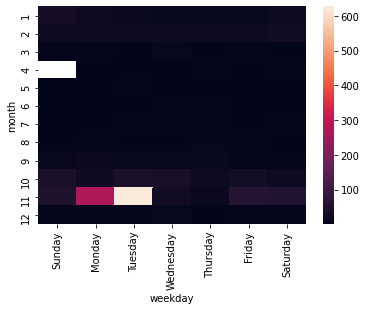

In [ ]:
fake_date_group = fake_news_final.groupby(by = ["month", "weekday"]).size().reset_index(name="count")
fake_date = fake_date_group.pivot("month", "weekday", "count")
x_axis_labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'] # labels for x-axis
ax = sns.heatmap(fake_date, xticklabels=x_axis_labels)

From above, seems like early in the week is the most popular time to post tweets and given the nature of the tweets, towards the election is when fake news came in the most

In [ ]:
fake_date_group.sort_values(by="count", ascending=False)

,month,weekday,count
71,11,2,627
70,11,1,272
74,11,5,61
75,11,6,59
69,11,0,51
...,...,...,...
28,5,1,1
16,3,2,1
33,5,6,1
34,6,0,1


### Text Cleaning and Sentiment Analysis

First, we want to remove punctuation and standardize the casing to lowercase

In [ ]:
def punctuation_removal(text):
  all_list = [char for char in text if char not in string.punctuation]
  clean_str=''.join(all_list)
  return clean_str

fake_news_final['clean_text'] = fake_news_final['text'].apply(lambda x : punctuation_removal(x.lower()))
real_news_final['clean_text'] = real_news_final['text'].apply(lambda x : punctuation_removal(x.lower()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Next, we want to remove stopwords to prevent them from skewing our results

In [ ]:
stop = stopwords.words('english')
fake_news_final['clean_text'] = fake_news_final['clean_text'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stop)]))
real_news_final['clean_text'] = real_news_final['clean_text'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stop)]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



From initial analysis, it appeared the tagnames realdonaldtrump, hillaryclinton and electionnight were heavily skewing the results in both type of text. Thus, we removed these in order to gain more meaningful insights

In [ ]:
import re
def filternames(text):
  newtext = text.replace('realdonaldtrump', '').replace('hillaryclinton', '').replace('electionnight', '').replace('electionday', '').replace('myvote2016', '')
  #remove all numbers
  newtext = re.sub(r'\w*\d\w*', '', newtext)
  #remove urls
  newtext = re.sub(r'http\S+', '', newtext)
  return newtext

fake_news_final['clean_text'] = fake_news_final['clean_text'].apply(lambda x : filternames(x))
real_news_final['clean_text'] = real_news_final['clean_text'].apply(lambda x : filternames(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Now that our text is cleaned up, we want to add sentiment and polarity scores to them to get a better idea of what the text is like

In [ ]:
def analyze_polarity(tweet):
  analysis = TextBlob(tweet)
  return analysis.sentiment.polarity

def analyze_subjectivity(tweet):
  analysis = TextBlob(tweet)
  return analysis.sentiment.subjectivity

fake_news_final['polarity'] = fake_news_final['clean_text'].apply(lambda x : analyze_polarity(x))
fake_news_final['subjectivity'] = fake_news_final['clean_text'].apply(lambda x : analyze_subjectivity(x))
real_news_final['polarity'] = real_news_final['clean_text'].apply(lambda x : analyze_polarity(x))
real_news_final['subjectivity'] = real_news_final['clean_text'].apply(lambda x : analyze_subjectivity(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

We will define "sucessful fake news" as any news with retweet count above the median retweet count of all post. We choose median instead of mean since there's a chance that the mean is heavily skewed based on a single popular tweet

In [ ]:
threshold = fake_news_final['retweet_count'].median()
real_news_top = real_news_final[real_news_final['retweet_count'] > threshold]
fake_news_top = fake_news_final[fake_news_final['retweet_count'] > threshold]

As seen below the most prominent fakenews words are derived from realdonaldtrump and hillaryclinton. If we look closer though we notice some interesting phrases and words such as "please simpson" "wikileaks" and"racism" to name a few

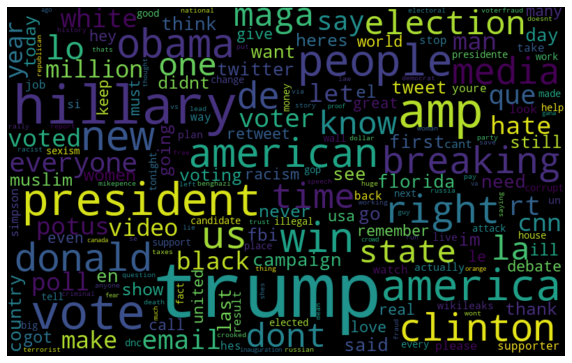

In [ ]:
all_words = ' '.join([text for text in fake_news_final.clean_text])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:

from sklearn.feature_extraction.text import CountVectorizer
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii',errors="ignore").decode('utf-8',errors="ignore") for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])



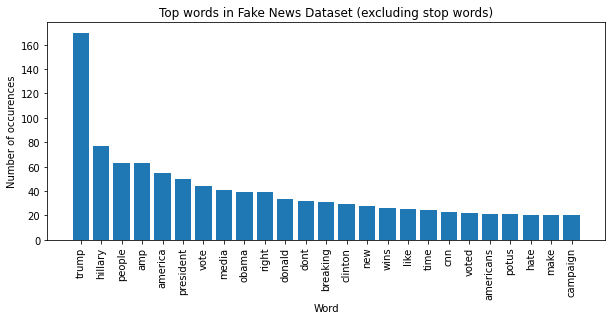

In [ ]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=25,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=fake_news_top['clean_text'])

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in Fake News Dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

### Topic Modeling

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
vectorizer = CountVectorizer(
analyzer='word',       
min_df=3,# minimum required occurences of a word 
stop_words='english',# remove stop words
lowercase=True,# convert all words to lowercase
token_pattern='[a-zA-Z0-9]{3,}',# num chars > 3
max_features=5000,# max number of unique words
                            )
data_matrix = vectorizer.fit_transform(fake_news_top['clean_text'])
data_matrix

<987x572 sparse matrix of type '<class 'numpy.int64'>'
	with 3882 stored elements in Compressed Sparse Row format>

In [ ]:
lda_model = LatentDirichletAllocation(
n_components=10, # Number of topics
learning_method='online',
random_state=10,       
n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_matrix)

In [ ]:
topics_list = []
for i,topic in enumerate(lda_model.components_):
  x = [vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]]
  print(f'Top 10 words for topic #{i}:')
  print(x)
  topics_list.append(x)
  print('\n') 

Top 10 words for topic #0:
['muslim', 'elected', 'media', 'stop', 'american', 'said', 'twitter', 'americans', 'potus', 'people']


Top 10 words for topic #1:
['new', 'got', 'great', 'black', 'let', 'cnn', 'trump', 'dont', 'like', 'amp']


Top 10 words for topic #2:
['mikepence', 'know', 'shes', 'question', 'lives', 'criminal', 'fbi', 'clinton', 'hillary', 'media']


Top 10 words for topic #3:
['hace', 'god', 'truth', 'climate', 'start', 'tweet', 'los', 'change', 'want', 'simpsons']


Top 10 words for topic #4:
['time', 'usa', 'term', 'dnc', 'state', 'woman', 'trumps', 'news', 'country', 'breaking']


Top 10 words for topic #5:
['voted', 'clinton', 'hate', 'obama', 'donald', 'hillary', 'vote', 'president', 'america', 'trump']


Top 10 words for topic #6:
['fear', 'different', 'didnt', 'video', 'today', 'sexism', 'emails', 'day', 'racism', 'campaign']


Top 10 words for topic #7:
['inauguration', 'actually', 'thats', 'real', 'trying', 'guy', 'new', 'house', 'white', 'amp']


Top 10 words

In [ ]:
sentences = []
i = 1
for words in topics_list:
  sentence = ''
  for x in words: 
    sentence = sentence + ' ' + x
  sentences.append(f"Topic {i}: " + sentence)
  i = i + 1

In [ ]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Table(header=dict(values=['Topics']),
                 cells=dict(values=[sentences]))])
fig.show()

### Who posts the most fake news?

First lets see who post the most amount of "fakes news"

In [ ]:
fake_sum = fake_news_top.groupby(by=['user_screen_name']).mean().reset_index()[['user_screen_name','retweet_count', 'user_followers_count']]
fake_total = fake_news_top.groupby(by=['user_screen_name']).size().reset_index(name="post_count").sort_values(by="post_count", ascending=False)

In [ ]:
fake_combo = fake_total.merge(fake_sum, on="user_screen_name")
fake_combo.sort_values(by=["post_count"], ascending=False).head(10)

,user_screen_name,post_count,retweet_count,user_followers_count
0,realDonaldTrump,62,5977.419355,1.749375e+07
1,JamesOKeefeIII,30,5798.733333,2.193511e+05
2,FoxNews,19,2987.000000,1.196921e+07
3,DineshDSouza,17,2611.352941,4.127712e+05
4,SheriffClarke,16,5430.000000,4.220609e+05
5,PrisonPlanet,16,3357.187500,3.367709e+05
6,DanScavino,16,3419.437500,2.299974e+05
7,Fahrenthold,15,5321.600000,2.289740e+05
8,elizabethforma,12,8171.166667,1.023658e+06
9,KellyannePolls,12,5035.000000,5.655594e+05


In [ ]:
px.bar(fake_combo.head(10), x="user_screen_name", y="post_count")

### Fake News Vs Real News

In [ ]:
def tTestFull(df1, df2, metrics, threshold): 
    '''
        Performs T-tests for all of the metrics passed as an argument
          on between data in df1 and df2.
    '''    
    
    print("ALPHA\t\t" + str(threshold))
    print()
    for metric in metrics:
      tTest = sm.stats.ttest_ind(df1[metric], df2[metric])
      if len(metric) < 8:
        result = metric.upper() + "\t\t" + str(tTest[1])
      else:
        result = metric.upper() + "\t" + str(tTest[1])

      if (tTest[1] < threshold):
        print(result + "\tREJECT")
      else:
        print(result + "\tFAIL TO REJECT")

I decided to see whether fake news had a significantly different text length than real news

In [ ]:
fake_news_final['text_length'] = fake_news_final['text'].apply(lambda x : len(x))
real_news_final['text_length'] = real_news_final['text'].apply(lambda x : len(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
metrics = ['polarity', 'text_length', 'user_friends_count', 'month']
tTestFull(fake_news_final, real_news_final, metrics, 0.05)

ALPHA		0.05

POLARITY	1.5764875745944168e-12	REJECT
TEXT_LENGTH	7.90791416961035e-06	REJECT
USER_FRIENDS_COUNT	1.6394362486809855e-05	REJECT
MONTH		1.7588483679727183e-46	REJECT


In [ ]:
fake_news_final.describe()

,category,retweet_count,user_friends_count,user_followers_count,weekday,month,polarity,subjectivity,text_length
count,1975.000000,1975.000000,1.975000e+03,1.975000e+03,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000
mean,2.629873,3258.008101,1.097082e+04,1.947744e+06,2.410127,8.864810,0.033487,0.280987,115.566582
std,1.843200,4475.113520,5.381778e+04,5.486028e+06,1.704900,3.555103,0.272247,0.327018,29.255859
min,-1.000000,1003.000000,0.000000e+00,1.000000e+01,0.000000,1.000000,-1.000000,0.000000,26.000000
25%,1.000000,1334.000000,2.540000e+02,3.226900e+04,1.000000,9.000000,0.000000,0.000000,97.000000
50%,3.000000,1962.000000,8.160000e+02,1.831670e+05,2.000000,11.000000,0.000000,0.100000,129.000000
75%,4.000000,3292.500000,4.052500e+03,7.141825e+05,3.000000,11.000000,0.100000,0.525126,139.000000
max,5.000000,70151.000000,1.679113e+06,9.419268e+07,6.000000,12.000000,1.000000,1.000000,150.000000


In [ ]:
real_news_final.describe()

,category,retweet_count,user_friends_count,user_followers_count,weekday,month,polarity,subjectivity,text_length
count,6445.000000,6445.000000,6445.000000,6.445000e+03,6445.000000,6445.000000,6445.000000,6445.000000,6445.000000
mean,-0.245151,3326.153297,6736.276338,3.223529e+06,2.742126,7.331575,0.088493,0.315131,118.777347
std,0.430210,5123.831583,31900.805192,8.855573e+06,1.828944,4.301964,0.310732,0.339713,27.504735
min,-1.000000,1001.000000,0.000000,1.000000e+00,0.000000,1.000000,-1.000000,0.000000,19.000000
25%,0.000000,1321.000000,199.000000,3.961300e+04,1.000000,2.000000,0.000000,0.000000,106.000000
50%,0.000000,1924.000000,706.000000,2.755570e+05,2.000000,10.000000,0.000000,0.200000,131.000000
75%,0.000000,3437.000000,2222.000000,1.259325e+06,4.000000,11.000000,0.200000,0.600000,139.000000
max,0.000000,99999.000000,946983.000000,9.568367e+07,6.000000,12.000000,1.000000,1.000000,155.000000


In [ ]:
fake_metric = fake_news_final.describe()[['polarity', 'text_length', 'user_friends_count', 'month']].loc[['mean']]
fake_df = pd.DataFrame({'month': fake_metric['month']['mean'], 'polarity': fake_metric['polarity']['mean'], 'text_length': fake_metric['text_length']['mean'], 'user_friend_count': fake_metric['user_friends_count']['mean']}, index=['fake'])

In [ ]:
real_metric = real_news_final.describe()[['polarity', 'text_length', 'user_friends_count', 'month']].loc[['mean']]
real_df = pd.DataFrame({'month': real_metric['month']['mean'], 'polarity': real_metric['polarity']['mean'], 'text_length': real_metric['text_length']['mean'], 'user_friend_count': real_metric['user_friends_count']['mean']}, index=['real'])

In [ ]:
fake_df.append(real_df)

,month,polarity,text_length,user_friend_count
fake,8.864810,0.033487,115.566582,10970.822785
real,7.331575,0.088493,118.777347,6736.276338


As seen above, it appears that on average, fake news is signficantly shorter than real news. Furthermore, given that a polarity score of 1 means the text is positive, -1 meaning negative sentiment and 0 being neutral, on average both texts are quite neutral. However, real news is significantly more positive than fake news (not surprising given what we saw above). Finally, it appears that the friend count of users that post fake news is on average significantly more than those that post real news. This can possibly explanation one aspect of the pervasive impacts fake news has on social networks. 

### Polarity vs Retweet Count

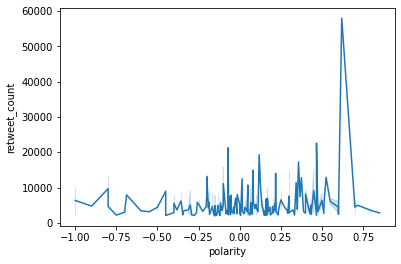

In [ ]:
sns.lineplot(x=fake_news_top['polarity'], y=fake_news_top['retweet_count'])

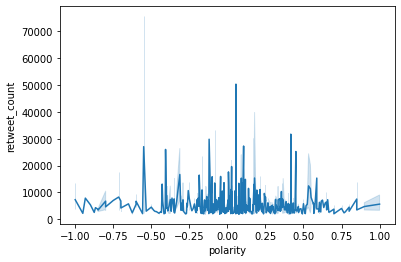

In [ ]:
sns.lineplot(x=real_news_top['polarity'], y=real_news_top['retweet_count'])

## Pre Processing

Before we can dive into training classifiers, we need to transform our features (the word counts) into numerical values to feed into the models. Thus, we will use Tfidfvectorizer to achieve this.

## TF-IDF

In [ ]:
#combine the two dataframes back into one
fake_news_final['type'] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
real_news_final['type'] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



We append the fake and real news datasets together and shuffle the rows in order to mix the data

In [ ]:
total_df = real_news_final.append(fake_news_final)
total_df
total_df_final = total_df.reset_index().drop(columns=['index'])

In [ ]:
X = []
for a in total_df_final['clean_text']:
  X.append(a)

y = []
for b in total_df_final['type']:
  y.append(b)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train,y_test= train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Keep words that appear in greater than 1% of documents. Override preprocessor and implement on list of words
#in each article in order to keep the words we have cleaned for earlier
tfidf = TfidfVectorizer(min_df = 0.01)

#Implement on train dataset
response_train = tfidf.fit_transform(x_train) #This is the Sparse Document-Term Matrix
feature_names_train = tfidf.get_feature_names()
dense_train = response_train.todense() #This is the Dense Document-Term Matrix
denselist_train = dense_train.tolist()

In [ ]:
df_train = pd.DataFrame(denselist_train, columns=feature_names_train)
df_train['label'] = y_train

In [ ]:
X_new = df_train.drop(columns=['label'])
y_new= df_train['label']

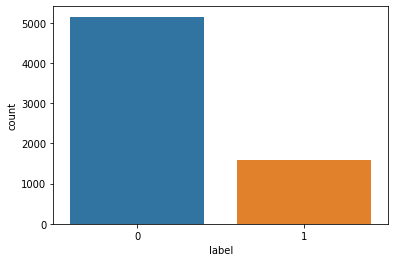

In [ ]:
sns.countplot(x = 'label', data=df_train)

Since the dataset is imbalanced, we need to oversample the fake news tweets

In [ ]:
#new training data
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=10)
x_ros, y_ros = ros.fit_resample(X_new, y_new)

print('The number of 0s in the class is: ', len(np.where(y_ros == 0)[0]))
print('The number of 1s in the class is: ', len(np.where(y_ros == 1)[0]))

x_train_new = x_ros
y_train_new = y_ros

The number of 0s in the class is:  5152
The number of 1s in the class is:  5152


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Keep words that appear in greater than 1% of documents. Override preprocessor and implement on list of words
#in each article in order to keep the words we have cleaned for earlier
tfidf = TfidfVectorizer(min_df = 0.01, vocabulary = feature_names_train)

#Implement on test dataset
response_test = tfidf.fit_transform(x_test) #This is the Sparse Document-Term Matrix
feature_names_test = tfidf.get_feature_names()
dense_test = response_test.todense() #This is the Dense Document-Term Matrix
denselist_test = dense_test.tolist()

In [ ]:
df_test = pd.DataFrame(denselist_test, columns=feature_names_test)
df_test['label'] = y_test
y_test_new = df_test['label'].values
x_test_new = df_test.drop(columns=["label"]).values

In [ ]:
x_test_new.shape

(1684, 101)

In [ ]:
x_train_new.shape

(10304, 101)

## Data Modeling

### Naive Bayes

In [ ]:
#Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report

nb = MultinomialNB().fit(x_train_new, y_train_new)
#Model Evaluation
y_pred_class = nb.predict(x_test_new)

In [ ]:
print("Accuracy is:", metrics.accuracy_score(y_test_new, y_pred_class))
print("Mean Squared Error is:", np.sqrt(mean_squared_error(y_test_new, y_pred_class)))

Accuracy is: 0.6419239904988123
Mean Squared Error is: 0.5983945266303726


In [ ]:
nb_cm = metrics.confusion_matrix(y_test_new, y_pred_class)
print(nb_cm)

[[922 371]
 [232 159]]


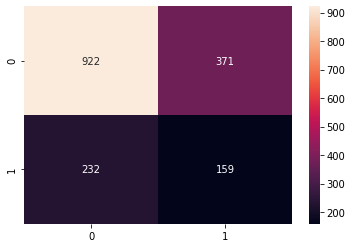

In [ ]:
labels =  np.array([['922','371'],['232','159']])
sns.heatmap(nb_cm, annot=labels, fmt = '')
plt.show()

In [ ]:
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.80      0.71      0.75      1293
           1       0.30      0.41      0.35       391

    accuracy                           0.64      1684
   macro avg       0.55      0.56      0.55      1684
weighted avg       0.68      0.64      0.66      1684



In [ ]:
#Number of times token appears in each True article
true_token = nb.feature_count_[0, :]

#Number of times token appears in each Fake article
fake_token = nb.feature_count_[1, :]

In [ ]:
tokens = pd.DataFrame({'token':feature_names_train, 'true':true_token, 'fake':fake_token}).set_index('token')
tokens.head()

,true,fake
token,,
america,128.870719,139.126799
american,68.612376,66.956614
americans,51.844322,80.164975
amp,264.196451,146.437197
back,54.248469,26.539833


In [ ]:
# add 1 to true and fake counts to avoid dividing by 0
tokens['true'] = tokens.true + 1
tokens['fake'] = tokens.fake + 1

In [ ]:
# convert the true and fake counts into frequencies
tokens['true'] = tokens.true / nb.class_count_[0]
tokens['fake'] = tokens.fake / nb.class_count_[1]

In [ ]:
# calculate the ratio of fake to true for each token
tokens['fake/true ratio'] = tokens.fake / tokens.true
tokens.sort_values('fake/true ratio', ascending=False).head(10)

,true,fake,fake/true ratio
token,,,
everyone,0.003761,0.016271,4.326051
breaking,0.007021,0.022992,3.274592
hillary,0.013917,0.041474,2.980158
media,0.008908,0.023719,2.662538
obama,0.010451,0.024911,2.383671
que,0.005987,0.013741,2.295143
la,0.005894,0.013489,2.288333
wins,0.007150,0.015262,2.134570
right,0.010925,0.023029,2.107848


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 1, max_depth = 420, n_estimators = 100)
rf.fit(x_train_new, y_train_new)
y_pred = rf.predict(x_test_new)

In [ ]:
print("Accuracy is:", metrics.accuracy_score(y_test_new, y_pred))
print("Mean Squared Error is:", np.sqrt(mean_squared_error(y_test_new, y_pred)))

Accuracy is: 0.581353919239905
Mean Squared Error is: 0.6470286552851389


In [ ]:
rf_cm = metrics.confusion_matrix(y_test, y_pred)
print(rf_cm)

[[782 511]
 [194 197]]


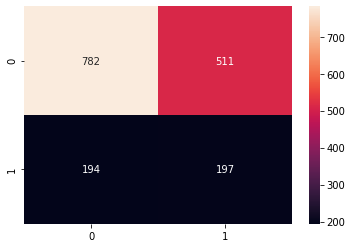

In [ ]:
labels = np.array([['782','511'],['194','197']])
sns.heatmap(rf_cm, annot=labels, fmt = '')
plt.show()

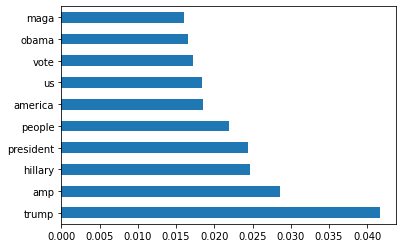

In [ ]:
feature_importances = pd.Series(rf.feature_importances_, index=feature_names_train)
feature_importances.nlargest(10).plot(kind='barh')